In [2]:
import numpy as np
import tigramite
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

# magic command for module reload
%load_ext autoreload
%autoreload 2

In [14]:

# Example time series data
np.random.seed(42)
time_series = np.random.randn(1000, 3)  # Simulated data: 1000 time points, 3 variables

# Initialize the data object for Tigramite
dataframe = pp.DataFrame(time_series, var_names=['var1', 'var2', 'var3'])

# Initialize PCMCI with tau_max set to 8
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr(significance='analytic')
)

# Run PCMCI with tau_max=8
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)

# Initialize an empty list to store significant links
significant_links = []

# Print significant links
print("Significant links at p < 0.05:")
for i in range(results['p_matrix'].shape[0]):
    for j in range(results['p_matrix'].shape[1]):
        for tau in range(results['p_matrix'].shape[2]):
            if results['p_matrix'][i, j, tau] < 0.05:
                print(f"({dataframe.var_names[i]}, {dataframe.var_names[j]}, lag {tau-1})")
                # Store the significant link with variable names and lag
                significant_links.append((dataframe.var_names[j], dataframe.var_names[i], tau-1))



Significant links at p < 0.05:
(var2, var1, lag 2)
(var2, var3, lag 0)


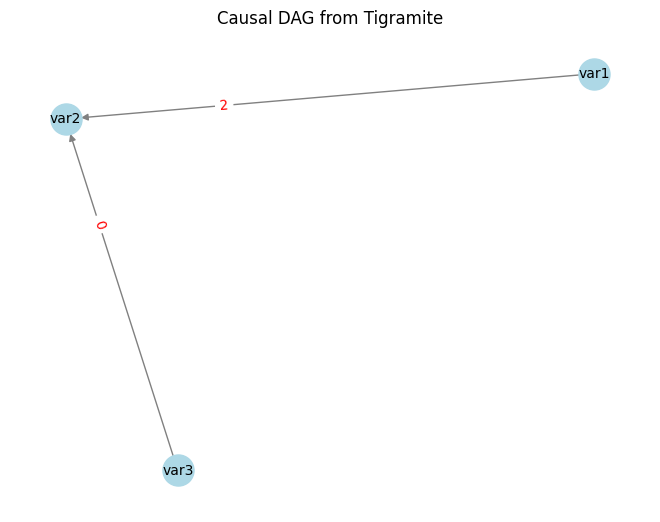

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each variable
for var_name in dataframe.var_names:
    G.add_node(var_name)

# Add edges for each significant link
for source, target, lag in significant_links:
    # Add an edge with the lag as a label
    G.add_edge(source, target, lag=lag)

# Draw the graph
pos = nx.spring_layout(G)  # Generate positions of nodes using spring layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

# Add edge labels to show lags
edge_labels = dict(((u, v), d['lag']) for u, v, d in G.edges(data=True))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_color='red')

plt.title("Causal DAG from Tigramite")
plt.show()




In [20]:
# fit a VAR model
from statsmodels.tsa.api import VAR
model = VAR(time_series)
results = model.fit(2)

# Get the lag order
lag_order = results.k_ar
print(f"Lag order: {lag_order}")

# Get the coefficients
coefficients = results.params
print(f"Coefficients:\n{coefficients}")

# Get the Granger causality matrix
granger_matrix = results.test_causality('var1', 'var2', kind='f').summary()
print(f"Granger causality matrix:\n{granger_matrix}")

Lag order: 2
Coefficients:
[[ 0.05096038 -0.00608684  0.04749994]
 [-0.01130433  0.00780571  0.0116465 ]
 [-0.01987566  0.02031255 -0.09422655]
 [-0.01670188  0.01182117  0.03731082]
 [ 0.05027825 -0.02787882 -0.0344348 ]
 [ 0.02123557 -0.01314036  0.04645479]
 [ 0.01442722  0.02411967 -0.03321129]]


ValueError: 'var1' is not in list